In [2]:
import numpy as np
# Train a model to classify real pulses vs. noise
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import awkward as ak
from tensorflow.keras.layers import Dropout
from tensorflow import keras
from tensorflow.keras import layers

2023-08-25 15:00:39.084948: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6fa5c/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-c1d8e/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib

In [9]:
num_events = 50000
num_samples = 10
xmin = 1
xmax = 10

In [10]:
def plot_timesamples(ax, time, emsignal_list, noisedata_list):
    #fig, ax = plt.subplots()
    for i, emsignal in enumerate(emsignal_list):
        noisedata = noisedata_list[i]
        ax.plot(time, emsignal, label=f'EM pulse' if i==1 else None, color='blue')
        ax.plot(time, noisedata, label=f'noise'  if i==1 else None,color='orange')
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Amplitude (arb. units)')
    ax.legend()

[[ 0.06895913  0.1056133  -0.09143379 ... -0.42161528 -0.29712962
  -0.58216445]
 [ 0.34485138 -0.08731802  0.06661344 ...  0.77302449  0.04550623
   0.00307311]
 [ 0.1237994   0.15758994  0.23702709 ...  0.74946809  0.89637208
   1.        ]
 ...
 [-0.03092482  0.05597267  0.02970392 ...  0.63602553  0.47977004
   0.197776  ]
 [-0.07213616  0.50158804  0.37323287 ...  0.94731449  1.
   0.95559548]
 [ 0.093267   -0.1169253  -0.21280756 ...  0.9604724   1.
   0.49827842]]
Printing y_real
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


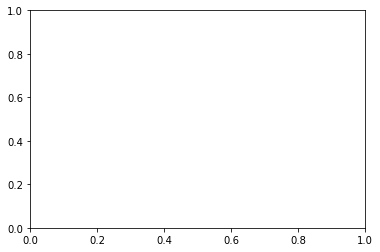

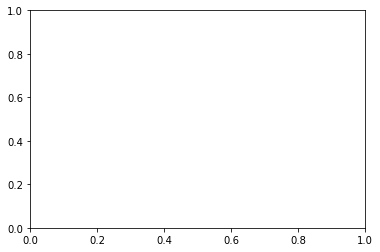

In [11]:
import uproot
### Energy = 0.15 GeV

root_file = uproot.open(f"/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/data/outputPSWithPU_withNoise_0.150000_0.15_v10.root")
tree = root_file["Samples"]
arrays = tree.arrays(["samples", "ysamples","samplesNoise","ysamplesNoise"])
X_real = ak.to_numpy(arrays["samples"])
y_real = ak.to_numpy(arrays["ysamples"])
X_noise = ak.to_numpy(arrays["samplesNoise"])
y_noise = ak.to_numpy(arrays["ysamplesNoise"])

print(X_real) 
print("Printing y_real")
print(y_real)

data = np.concatenate([X_real, X_noise]) ### makes it [2*num_events,num_samples]
labels = np.concatenate([y_real,y_noise])

# Shuffle data and labels together
## Important to shuffle since I take some fraction of events so it should not happen that all the real events 
## are cluttered at the beginning
shuffle_indices = np.random.permutation(len(data))
data = data[shuffle_indices]
labels = labels[shuffle_indices]

fig, ax = plt.subplots()
import awkward as ak

num_events = ak.num(X_real, axis=0)
t_events = np.zeros((num_events, num_samples))
for i in range(num_events):
    t_event = np.linspace(xmin, xmax, 10)
    t_events[i] = t_event
###replace this block with actual time variable

fig, ax = plt.subplots()
ev_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9 , 10, 100, 200, 300]# list of event numbers to plot
#ev_numbers = [1500]
emsignal_list = [X_real[ev_number] for ev_number in ev_numbers]
noisedata_list = [X_noise[ev_number] for ev_number in ev_numbers]
#plot_timesamples(ax, t_events[ev_numbers[0]], emsignal_list, noisedata_list)
#plt.show()

In [12]:
print(f'type of data is {type(data)}')

import awkward as ak

num_events_data = ak.num(data, axis=0)
print(f'number of rows in data is {num_events_data}')


ntimeSamples_data = ak.num(data, axis=1)
print(f'number of rows in data is {ntimeSamples_data[0]}') ## just take the 0th event

# Split into train and test sets
train_size = int(0.8 * num_events_data) ###times 2 because the noise is also in the same dataset, so it is 2*num_events
train_data = data[:train_size]
train_labels = labels[:train_size]
test_data = data[train_size:]
test_labels = labels[train_size:]

type of data is <class 'numpy.ndarray'>
number of rows in data is 400000
number of rows in data is 10


In [6]:
print(f'Size of training data is {train_size}')


print(f'number of elements in data : training data : test data : {len(data)} : {len(train_data)} : {len(test_data)}')


### LSTM Bidirectional model with one more LSTM layer + sigmoid
inputs = (ntimeSamples_data[0], 1)
model1 = keras.Sequential()
model1.add(layers.Bidirectional(layers.LSTM(64, activation='relu', return_sequences=True), input_shape=(ntimeSamples_data[0], 1)))
model1.add(layers.Bidirectional(layers.LSTM(32, activation='relu')))
model1.add(layers.Dense(1, activation='relu'))
model1.summary()

# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model1.fit(train_data[..., np.newaxis], train_labels, epochs=10, batch_size=64, validation_split=0.2)

# Save the model to a file
model1.save('/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/model/timeSeries_LSTMmodel_v10_relu_v1.h5')

# Evaluate model
test_loss, test_acc = model1.evaluate(test_data[..., np.newaxis], test_labels)
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')


Size of training data is 320000
number of elements in data : training data : test data : 400000 : 320000 : 80000
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 10, 128)          33792     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 75,073
Trainable params: 75,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
4000/4000 [==============================] - 140s 33ms/step 

In [7]:
print(f'Size of training data is {train_size}')


print(f'number of elements in data : training data : test data : {len(data)} : {len(train_data)} : {len(test_data)}')


### LSTM Bidirectional model with one more LSTM layer + sigmoid
#inputs = (ntimeSamples_data[0], 1)
model = keras.Sequential()
model.add(layers.Bidirectional(layers.LSTM(64, activation='relu', return_sequences=True), input_shape=(ntimeSamples_data[0], 1)))
model.add(layers.Bidirectional(layers.LSTM(32, activation='relu')))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_data[..., np.newaxis], train_labels, epochs=10, batch_size=64, validation_split=0.2)

# Save the model to a file
model.save('/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/model/timeSeries_LSTMmodel_v10_sigmoid_v1.h5')

# Evaluate model
test_loss, test_acc = model.evaluate(test_data[..., np.newaxis], test_labels)
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')


Size of training data is 320000
number of elements in data : training data : test data : 400000 : 320000 : 80000
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 10, 128)          33792     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 75,073
Trainable params: 75,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
4000/4000 [==============================] - 141s 34ms/ste

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



In [ ]:
# Make predictions on test data
predictions = model.predict(test_data[..., np.newaxis]).flatten()
# Convert predictions to binary labels
binary_predictions = (predictions > 0.5).astype(int)

print(f'{len(test_labels)} and {len(binary_predictions)}')
print(f" predictions are {predictions}")
# Create scatter plot of true labels vs. predicted labels
plt.scatter(test_labels, predictions, alpha=0.1)
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('True Labels vs. Predicted Labels')
plt.show()


In [1]:
new_model = tf.keras.models.load_model('/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/model/timeSeries_LSTMmodel_v10_relu.h5')
predictions2 = new_model.predict(test_data[..., np.newaxis]).flatten()

NameError: name 'tf' is not defined

In [37]:
np.count_nonzero(predictions2[test_labels[:,0] == 1] > 0.5)

31578

In [38]:
np.count_nonzero(test_labels[:,0] == 1)

40017

In [39]:
np.count_nonzero(predictions2[test_labels[:,0] == 0] > 0.5)

10305

In [20]:
((predictions > 0.5) == (test_labels[:,0] == 1))

NameError: name 'predictions' is not defined

test labels are: [1. 1. 0. ... 1. 0. 0.]
[0.21400686 0.39911163 0.4719287  ... 0.6321563  0.14593337 0.05864598]
[0.40870237 0.89884496 0.8646379  ... 0.7239078  0.7742245  0.8321794 ]


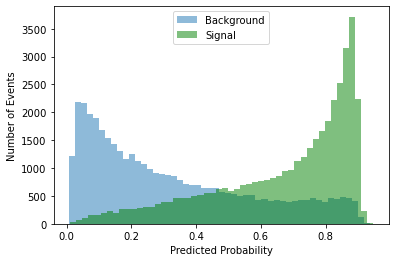

In [33]:
###plot the score

print(f'test labels are: {test_labels[:,0]}')

# Create separate arrays for background and signal predictions
bkg_preds = predictions2[test_labels[:,0] == 0]
sig_preds = predictions2[test_labels[:,0] == 1]

print(bkg_preds)
print(sig_preds)
# Plot the predicted probabilities
plt.hist(bkg_preds, bins=50, label='Background', alpha=0.5)
plt.hist(sig_preds, bins=50, label='Signal', alpha=0.5, color='green')
plt.xlabel('Predicted Probability')
plt.ylabel('Number of Events')
plt.legend(loc='upper center')
#plt.ylim(top=100)
#plt.show()
plt.savefig("bkgVsSig_v10_relu.png")

test labels are: [1. 1. 0. ... 1. 0. 0.]
[0.20494266 0.33767927 0.54940146 ... 0.6406661  0.14520815 0.06635542]
[0.44717854 0.89989877 0.8433898  ... 0.7686749  0.7664459  0.7922409 ]


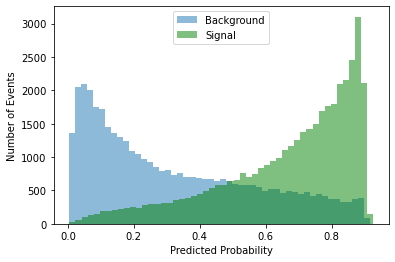

In [35]:
###plot the score

print(f'test labels are: {test_labels[:,0]}')

# Create separate arrays for background and signal predictions
bkg_preds = predictions2[test_labels[:,0] == 0]
sig_preds = predictions2[test_labels[:,0] == 1]

print(bkg_preds)
print(sig_preds)
# Plot the predicted probabilities
plt.hist(bkg_preds, bins=50, label='Background', alpha=0.5)
plt.hist(sig_preds, bins=50, label='Signal', alpha=0.5, color='green')
plt.xlabel('Predicted Probability')
plt.ylabel('Number of Events')
plt.legend(loc='upper center')
#plt.ylim(top=100)
#plt.show()
plt.savefig("bkgVsSig_v10_relu.png")

In [ ]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.xlim([0.9, 1])
#plt.ylim([0.999, 1.005])
#plt.show()
plt.savefig("ROC_v10.png")

In [ ]:
### precision recall curve
# Calculate precision-recall curve and average precision
precision, recall, _ = precision_recall_curve(test_labels, predictions)
average_precision = average_precision_score(test_labels, predictions)

# Plot precision-recall curve
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()